In [1]:
from pydantic import BaseModel, field_validator, ValidationError, PositiveInt
from dataclasses import dataclass
from typing import Literal
from typing_extensions import TypedDict
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


**Breakdown:**

- Defines a `TypedDict` expecting `name: str` and `age: int`.
- Creates a value where `age` is incorrectly a string (`"42"`).
- Prints the dict and the real runtime type.

**Result:**  
`TypedDict` does **not** enforce types at runtime—`age` stays a `str`.


In [ ]:
class UserTD(TypedDict):
    name: str
    age: int

u: UserTD = {"name": "Alice", "age": "42"}  
print(u, type(u["age"]))  

{'name': 'Alice', 'age': '42'} <class 'str'>


**Breakdown:**

- Defines a `dataclass` expecting `name: str` and `age: int`.
- Creates an instance with `age="42"` (a string).
- Prints the object and the actual type of `user.age`.

**Result:**  
`dataclass` also does **not** enforce types at runtime—`age` ends up as a `str` even though it's annotated as an `int`.


In [ ]:
@dataclass
class UserDC:
    name: str
    age: int

user = UserDC(name="Bob", age="42") 
print(user, type(user.age)) 

UserDC(name='Bob', age='42') <class 'str'>


**Breakdown:**

- Defines a Pydantic model expecting `name: str` and `age: int`.
- Creates `ok` with `age="42"` (a string).
- Pydantic **parses/coerces** `"42"` into the integer `42`.
- Prints the object and the type of `ok.age`.

**Result:**  
Unlike `TypedDict` and `dataclass`, Pydantic **enforces and converts** types—`age` becomes an `int`.


In [2]:
class UserPD(BaseModel):
    name: str
    age: int

ok = UserPD(name="Carol", age="42")
print(ok, type(ok.age))


name='Carol' age=42 <class 'int'>


**Breakdown:**

- Defines a Pydantic model with:
  - `name: str`
  - `age: PositiveInt` (must be a strictly positive integer).
- Tries to create `StrictUserPD` with `age=-5`.
- Pydantic raises a `ValidationError`, which is caught and printed.

**Result:**  
Pydantic with `PositiveInt` **rejects invalid data** (negative ages) instead of accepting or coercing it.


In [3]:
class StrictUserPD(BaseModel):
    name: str
    age: PositiveInt

try:
    bad = StrictUserPD(name="Dan", age=-5) 
except ValidationError as e:
    print("ValidationError:", e)

ValidationError: 1 validation error for StrictUserPD
age
  Input should be greater than 0 [type=greater_than, input_value=-5, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/greater_than


**Breakdown:**

- Defines a `TypedDict` state with:
  - `email: str`
  - `plan: "premium" | "vip"`
- Nodes:
  - `entry_node`: passes through the `email`.
  - `upgrade_premium`: sets `plan` to `"premium"`.
  - `upgrade_vip`: sets `plan` to `"vip"`.
- `upgrade_checker` randomly routes to `"upgrade_vip"` or `"upgrade_premium"`.
- Builds a LangGraph:
  - Flow: **START → entry_node → (upgrade_vip or upgrade_premium) → END**.
- Compiles the graph and displays its diagram.

**Result:**  
A small branching upgrade flow that randomly upgrades a user to **premium** or **vip** and visualizes the graph.


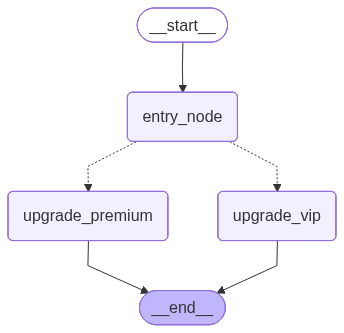

In [4]:
class TypedDictStateDemo(TypedDict):
    email: str
    plan: Literal["premium", "vip"]


def entry_node(state):
    print("*****first_node*****")
    return {"email": state['email'] }

def upgrade_premium(state):
    print("*****upgrade_premium*****")
    return {"plan": "premium"}

def upgrade_vip(state):
    print("*****upgrade_vip*****")
    return {"plan": "vip"}

def upgrade_checker(state) -> Literal["upgrade_vip", "upgrade_premium"]:        
    return "upgrade_vip" if random.random() < 0.5 else "upgrade_premium"


upgrade_graph = StateGraph(TypedDictStateDemo)
upgrade_graph.add_node("entry_node", entry_node)
upgrade_graph.add_node("upgrade_premium", upgrade_premium)
upgrade_graph.add_node("upgrade_vip", upgrade_vip)

upgrade_graph.add_edge(START, "entry_node")
upgrade_graph.add_conditional_edges("entry_node", upgrade_checker)
upgrade_graph.add_edge("upgrade_vip", END)
upgrade_graph.add_edge("upgrade_premium", END)

graph = upgrade_graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


Runs the graph with `{"email": "a@b.com"}` and returns whichever upgrade branch was chosen:

- `{"email": "a@b.com", "plan": "vip"}` **or**
- `{"email": "a@b.com", "plan": "premium"}`

A single execute of the upgrade flow.


In [5]:
graph.invoke({"email":"a@b.com"})

*****first_node*****
*****upgrade_premium*****


{'email': 'a@b.com', 'plan': 'premium'}

Runs the graph with `{"email": 123}` even though `email` should be a string.  
Because it's a `TypedDict` graph, **no validation is enforced**, so the graph accepts the bad type and still runs the upgrade flow.


In [7]:
graph.invoke({"email": 123})

*****first_node*****
*****upgrade_vip*****


{'email': 123, 'plan': 'vip'}

Runs the graph with `{"email": 123, "plan": "gold"}` even though:
- `email` should be a `str`
- `plan` should be `"premium"` or `"vip"`

Because this is a `TypedDict` graph, **no runtime validation is enforced**, so both the wrong type and invalid plan value are accepted and the flow still runs.

In [6]:
graph.invoke({"email": 123, 'plan': 'gold'})

*****first_node*****
*****upgrade_premium*****


{'email': 123, 'plan': 'premium'}

**Breakdown:**

- Still uses a `TypedDict` state with:
  - `email: str`
  - `plan: "premium" | "vip"`
- Adds **manual runtime guardrails** inside `entry_node`:
  - If `email` is **not** a `str` → `TypeError`
  - If `plan` exists but is not `"premium"` or `"vip"` → `ValueError`
- The rest of the graph is the same:
  - `START → entry_node → (upgrade_vip or upgrade_premium) → END`
  - `upgrade_premium` / `upgrade_vip` set the `plan` value.

**Result:**  
A `TypedDict`-based LangGraph where type and value checks are enforced **manually in code**, not by `TypedDict` itself.


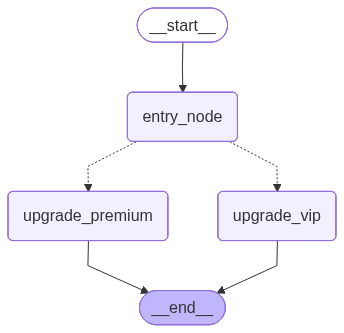

In [7]:
class TypedDictStateDemo(TypedDict):
    email: str
    plan: Literal["premium", "vip"]

def entry_node(state):
    print("*****first_node*****")
    # Runtime guardrails
    if not isinstance(state.get("email"), str):
        raise TypeError(f"email must be str, got {type(state.get('email')).__name__}")
    if "plan" in state and state["plan"] not in {"premium", "vip"}:
        raise ValueError(f"plan must be 'premium' or 'vip', got {state['plan']}")
    print("*****first_node*****")
    return {"email": state["email"]}


def upgrade_premium(state):
    print("*****upgrade_premium*****")
    return {"plan": "premium"}

def upgrade_vip(state):
    print("*****upgrade_vip*****")
    return {"plan": "vip"}

def upgrade_checker(state) -> Literal["upgrade_vip", "upgrade_premium"]:        
    return "upgrade_vip" if random.random() < 0.5 else "upgrade_premium"


upgrade_graph = StateGraph(TypedDictStateDemo)
upgrade_graph.add_node("entry_node", entry_node)
upgrade_graph.add_node("upgrade_premium", upgrade_premium)
upgrade_graph.add_node("upgrade_vip", upgrade_vip)

upgrade_graph.add_edge(START, "entry_node")
upgrade_graph.add_conditional_edges("entry_node", upgrade_checker)
upgrade_graph.add_edge("upgrade_vip", END)
upgrade_graph.add_edge("upgrade_premium", END)

graph = upgrade_graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Calls the guarded graph with `{"email": 123}`.

- In `entry_node`, the runtime check `isinstance(email, str)` fails.
- A `TypeError` is raised: `email must be str, got int`.

**Result:**  
Bad input is **rejected** instead of silently flowing through the graph.


In [10]:
graph.invoke({"email": 123})

*****first_node*****


TypeError: email must be str, got int

Calls the guarded graph with `{"email": "123", "plan": "gold"}`.

- `email` is a valid `str`, so the first check passes.
- `"gold"` is **not** `"premium"` or `"vip"`, so the second check fails.
- `entry_node` raises a `ValueError`:  
  `plan must be 'premium' or 'vip', got gold`.

**Result:**  
Invalid plan values are **blocked** by the manual runtime guardrails.


In [11]:
graph.invoke({"email": "123", 'plan': 'gold'})

*****first_node*****


ValueError: plan must be 'premium' or 'vip', got gold

**Breakdown:**

- Defines a `dataclass` state:

  - `email: str`
  - `plan: "premium" | "vip"`

- Dataclass benefit:  
  **You access fields with dot notation** (`state.email`) instead of square brackets (`state["email"]`), which is easier to read and less error-prone.

- Nodes:
  - `entry_node`: returns `{"email": state.email}`.
  - `upgrade_premium`: sets `plan` to `"premium"`.
  - `upgrade_vip`: sets `plan` to `"vip"`.

- Conditional routing:
  - `upgrade_checker` randomly chooses `"upgrade_vip"` or `"upgrade_premium"`.

- Graph flow:  
  **START → entry_node → (upgrade_vip or upgrade_premium) → END**

**Result:**  
A dataclass-based LangGraph that’s cleaner to work with because of dot-access, but still has **no runtime type enforcement**—dataclasses don’t validate values.


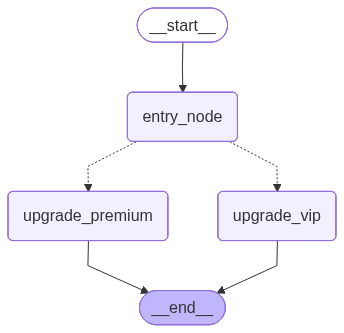

In [8]:
@dataclass
class DataclassStateDemo:
    email: str
    plan: Literal["premium", "vip"]    


def entry_node(state):
    print("*****first_node*****")
    return {"email": state.email }

def upgrade_premium(state):
    print("*****upgrade_premium*****")
    return {"plan": "premium"}

def upgrade_vip(state):
    print("*****upgrade_vip*****")
    return {"plan": "vip"}

def upgrade_checker(state) -> Literal["upgrade_vip", "upgrade_premium"]:        
    return "upgrade_vip" if random.random() < 0.5 else "upgrade_premium"


upgrade_graph = StateGraph(DataclassStateDemo)
upgrade_graph.add_node("entry_node", entry_node)
upgrade_graph.add_node("upgrade_premium", upgrade_premium)
upgrade_graph.add_node("upgrade_vip", upgrade_vip)

upgrade_graph.add_edge(START, "entry_node")
upgrade_graph.add_conditional_edges("entry_node", upgrade_checker)
upgrade_graph.add_edge("upgrade_vip", END)
upgrade_graph.add_edge("upgrade_premium", END)

graph = upgrade_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Runs the dataclass-based graph with `{'email': 123, 'plan': 'gold'}`.

- Even though the dataclass says `email: str` and `plan: "premium" | "vip"`,  
  **dataclasses do not validate types at runtime**.
- So the graph accepts the bad values and still runs normally.

**Result:**  
Invalid types and invalid literal values **are not blocked** — the flow executes with whatever you pass in.


In [9]:
graph.invoke({'email': 123, 'plan': 'gold'})

*****first_node*****
*****upgrade_vip*****


{'email': 123, 'plan': 'vip'}

**Breakdown:**

- Uses a `dataclass` state:

  - `email: str`
  - `plan: "premium" | "vip"`

- `entry_node` adds **manual runtime guardrails** with dot notation:
  - If `email` is not a `str` → `TypeError`.
  - Intends to check `plan` is `"premium"` or `"vip"` and raise `ValueError` otherwise.

- `upgrade_premium` / `upgrade_vip` set `plan` to `"premium"` or `"vip"`.
- `upgrade_checker` randomly picks one upgrade node.
- Graph flow: **START → entry_node → (upgrade_vip or upgrade_premium) → END**.

**Result:**  
A dataclass-based LangGraph where validation is handled **explicitly in the node code** (using dot-access), rather than by the dataclass type hints themselves.


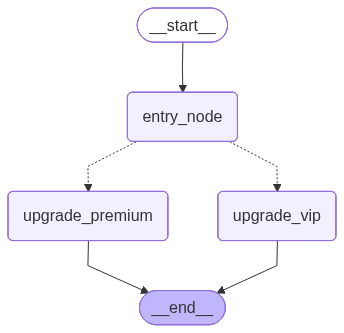

In [10]:
@dataclass
class DataclassStateDemo:
    email: str
    plan: Literal["premium", "vip"]    


def entry_node(state):
    print("*****first_node*****")
    # Runtime guardrails
    if not isinstance(state.email, str):
        raise TypeError(f"email must be str, got {type(state.email).__name__}")
    if "plan" in state and state.plan not in {"premium", "vip"}:
        raise ValueError(f"plan must be 'premium' or 'vip', got {state.plan}")
    print("*****first_node*****")
    return {"email": state.email}

def upgrade_premium(state):
    print("*****upgrade_premium*****")
    return {"plan": "premium"}

def upgrade_vip(state):
    print("*****upgrade_vip*****")
    return {"plan": "vip"}

def upgrade_checker(state) -> Literal["upgrade_vip", "upgrade_premium"]:        
    return "upgrade_vip" if random.random() < 0.5 else "upgrade_premium"


upgrade_graph = StateGraph(DataclassStateDemo)
upgrade_graph.add_node("entry_node", entry_node)
upgrade_graph.add_node("upgrade_premium", upgrade_premium)
upgrade_graph.add_node("upgrade_vip", upgrade_vip)

upgrade_graph.add_edge(START, "entry_node")
upgrade_graph.add_conditional_edges("entry_node", upgrade_checker)
upgrade_graph.add_edge("upgrade_vip", END)
upgrade_graph.add_edge("upgrade_premium", END)

graph = upgrade_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Running `graph.invoke({"email": 123, "plan": "vip"})` fails immediately because the manual guardrail in `entry_node` sees that `email` is not a string and raises a `TypeError`. 

In [11]:
graph.invoke({"email": 123, 'plan': 'vip'})

*****first_node*****


TypeError: email must be str, got int

Running `graph.invoke({"email": "a@b.com", "plan": "gold"})` triggers the manual guardrail in `entry_node` because `"gold"` is not `"premium"` or `"vip"`, so it raises a `ValueError`.

In [12]:
graph.invoke({'email': "a@b.com", 'plan': 'gold'})

*****first_node*****


TypeError: argument of type 'DataclassStateDemo' is not iterable

**Breakdown:**

- Defines a Pydantic model with:
  - `email: str`
  - `plan: str`
- Adds a `@field_validator("plan")` that only allows `"premium"` or `"vip"`.
- Tries to create `PydanticStateDemo(email="a@b.com", plan="gold")`.
- `"gold"` is invalid, so Pydantic raises a `ValidationError`, which is caught and printed.

**Result:**  
Pydantic enforces the allowed `plan` values at creation time and blocks `"gold"`.


In [13]:
class PydanticStateDemo(BaseModel):
    email: str
    plan: str 

    @field_validator('plan')
    @classmethod
    def validate_plan(cls, value):
        if value not in ["premium", "vip"]:
            raise ValueError("Plan Values Allowed[premium, vip]")
        return value


try:
    state = PydanticStateDemo(email="a@b.com", plan="gold")
except ValidationError as e:
    print("Validation Error:", e)


Validation Error: 1 validation error for PydanticStateDemo
plan
  Value error, Plan Values Allowed[premium, vip] [type=value_error, input_value='gold', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error


**Breakdown:**

- Uses `PydanticStateDemo` as the LangGraph state type.
- Nodes (using dot notation for clarity):
  - `entry_node`: returns `{"email": state.email}`.
  - `upgrade_premium`: sets `plan` to `"premium"`.
  - `upgrade_vip`: sets `plan` to `"vip"`.
- `upgrade_checker` randomly routes to `"upgrade_vip"` or `"upgrade_premium"`.
- Graph flow: **START → entry_node → (upgrade_vip or upgrade_premium) → END**.

**Result:**  
A Pydantic-backed upgrade graph: Pydantic handles validation when the state is created, and inside the graph you get clean, dot-style access (`state.email`, `state.plan`).


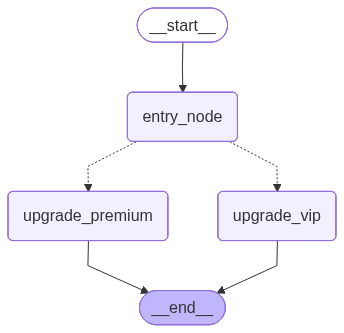

In [16]:
def entry_node(state):
    print("*****first_node*****")
    return {"email": state.email }

def upgrade_premium(state):
    print("*****upgrade_premium*****")
    return {"plan": "premium"}

def upgrade_vip(state):
    print("*****upgrade_vip*****")
    return {"plan": "vip"}

def upgrade_checker(state) -> Literal["upgrade_vip", "upgrade_premium"]:        
    return "upgrade_vip" if random.random() < 0.5 else "upgrade_premium"
    
upgrade_graph = StateGraph(PydanticStateDemo)
upgrade_graph.add_node("entry_node", entry_node)
upgrade_graph.add_node("upgrade_premium", upgrade_premium)
upgrade_graph.add_node("upgrade_vip", upgrade_vip)

upgrade_graph.add_edge(START, "entry_node")
upgrade_graph.add_conditional_edges("entry_node", upgrade_checker)
upgrade_graph.add_edge("upgrade_vip", END)
upgrade_graph.add_edge("upgrade_premium", END)
graph = upgrade_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Running  
`graph.invoke(PydanticStateDemo(email="a@b.com", plan="vip"))`  
works normally because Pydantic already validated the state.

**Result:**  
A valid Pydantic object enters the graph, `entry_node` runs, and the flow upgrades the user to either **premium** or **vip** based on the random branch.


In [17]:
graph.invoke(PydanticStateDemo(email="a@b.com", plan="vip"))

*****first_node*****
*****upgrade_vip*****


{'email': 'a@b.com', 'plan': 'vip'}

Running  
`graph.invoke(PydanticStateDemo(email="a@b.com", plan="gold"))`  
never reaches the graph: Pydantic rejects `"gold"` at object creation time and raises a `ValidationError`, so the graph is **never invoked**.


In [18]:
graph.invoke(PydanticStateDemo(email="a@b.com", plan="gold"))

ValidationError: 1 validation error for PydanticStateDemo
plan
  Value error, Plan Values Allowed[premium, vip] [type=value_error, input_value='gold', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error